In [1]:
import mne
from mne.datasets import sample
from mne.minimum_norm import (make_inverse_operator, apply_inverse,
                              write_inverse_operator)
import matplotlib.pyplot as plt

In [2]:
#tEEG subject (Choose ps,ct)
tEEG_id='ps'

In [3]:
%matplotlib inline

In [4]:
# The paths to freesurfer reconstructions (head model)
subjects_dir ='MNE-sample-data/subjects'
subject = 'sample'
#tEEG recording
raw = mne.io.read_raw_eeglab(tEEG_id+'_vep_teeg.set', preload=True,)  # load data 
mne.set_eeg_reference(raw, ref_channels=[])

Reading ps_vep_teeg.fdt
Reading 0 ... 566099  =      0.000 ...  1132.198 secs...
Applying a custom EEG reference.


(<RawEEGLAB  |  ps_vep_teeg.fdt, n_channels x n_times : 17 x 566100 (1132.2 sec), ~73.5 MB, data loaded>,
 None)

In [5]:
raw.filter(l_freq=None, h_freq=40.0)  # low-pass filter data

Low-pass filtering at 40 Hz
Multiple deprecated filter parameters were used:
phase in 0.13 is "zero-double" but will change to "zero" in 0.14
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
upper transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
The default filter length in 0.13 is "10s" but will change to "auto" in 0.14


<ipython-input-5-effa67b1dd64>:1: DeprecationWarning: Multiple deprecated filter parameters were used:
phase in 0.13 is "zero-double" but will change to "zero" in 0.14
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
upper transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
The default filter length in 0.13 is "10s" but will change to "auto" in 0.14
  raw.filter(l_freq=None, h_freq=40.0)  # low-pass filter data


<RawEEGLAB  |  ps_vep_teeg.fdt, n_channels x n_times : 17 x 566100 (1132.2 sec), ~73.5 MB, data loaded>

In [6]:
# Extract epochs and save them:
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False,  
                       exclude='bads')  
events = mne.find_events(raw, shortest_event=1, stim_channel='STI 014') 

reject = dict(eeg=1500e-6)  #threshold rejection
epochs = mne.Epochs(raw, events, event_id=49151, tmin=-0.1, tmax=0.3,  
                    proj=True, picks=picks, baseline=(None, 0),  
                    preload=True, reject=reject)

1201 events found
Events id: [49151 65535]
600 matching events found
Applying baseline correction (mode: mean)
add_eeg_ref defaults to True in 0.13, will default to False in 0.14, and will be removed in 0.15. We recommend to use add_eeg_ref=False and set_eeg_reference() instead.
Adding average EEG reference projection.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 600 events and 201 original time points ...


<ipython-input-6-274a6ceed900>:9: DeprecationWarning: add_eeg_ref defaults to True in 0.13, will default to False in 0.14, and will be removed in 0.15. We recommend to use add_eeg_ref=False and set_eeg_reference() instead.
  preload=True, reject=reject)


0 bad epochs dropped


In [7]:
#save dataset information
epochs.save(tEEG_id+'-epo.fif')

Estimating covariance using SHRUNK
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
Number of samples used : 30600
[done]
Number of samples used : 30600
[done]
log-likelihood on unseen data (descending order):
   shrunk: -71.114
   empirical: -91.171
selecting best estimator: shrunk


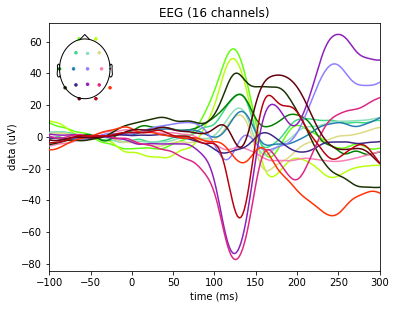

C:\Users\chris\Anaconda3\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


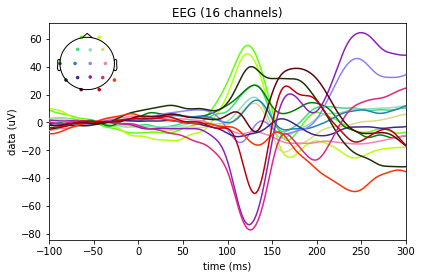

In [8]:
# Compute evoked response and noise covariance
evoked = epochs.average()  
noise_cov = mne.compute_covariance(epochs, tmax=0,method=['shrunk', 'empirical'])  
evoked.plot(spatial_colors=True)  # plot evoked 

In [9]:
#Source localization - forward model
src = mne.setup_source_space(subject, spacing='oct6',
                             subjects_dir=subjects_dir,
                             add_dist=False, overwrite=True) #set up source space with sample head model
mne.write_source_spaces(tEEG_id+'-oct6-src.fif', src) #write to file

Setting up the source space with the following parameters:

SUBJECTS_DIR = MNE-sample-data/subjects
Subject      = sample
Surface      = white
Octahedron subdivision grade 6

>>> 1. Creating the source space file MNE-sample-data/subjects\sample\bem\sample-oct-6-src.fif...
Doing the octahedral vertex picking...
Loading MNE-sample-data/subjects\sample\surf\lh.white...
Triangle file: b'created by gramfort on Thu Sep 15 19:44:31 2011' nvert = 155407 ntri = 310810
    Triangle neighbors and vertex normals...
Loading geometry from MNE-sample-data/subjects\sample\surf\lh.sphere...
Triangle file: b'created by gramfort on Thu Sep 15 20:42:21 2011' nvert = 155407 ntri = 310810
Mapping lh sample -> oct (6) ...
Setting up the triangulation for the decimated surface...
loaded lh.white 4098/155407 selected to source space (oct = 6)

Loading MNE-sample-data/subjects\sample\surf\rh.white...
Triangle file: b'created by gramfort on Thu Sep 15 22:04:14 2011' nvert = 156866 ntri = 313728
    Triangle neig

In [10]:
conductivity = (0.3, 0.006, 0.3)  # for three layers

In [11]:
model = mne.make_bem_model(subject='sample', ico=4,
                           conductivity=conductivity,
                           subjects_dir=subjects_dir) #make bem model

Creating the BEM geometry...
Going from 4th to 4th subdivision of an icosahedron (n_tri: 5120 -> 5120)
Going from 4th to 4th subdivision of an icosahedron (n_tri: 5120 -> 5120)
Going from 4th to 4th subdivision of an icosahedron (n_tri: 5120 -> 5120)
outer skin  CM is  -0.12  -0.14  22.79 mm
outer skull CM is   0.70  -9.88  44.01 mm
inner skull CM is   0.67 -10.01  44.26 mm
Checking that outer skull surface is inside outer skin  surface...
Checking that inner skull surface is inside outer skull surface...
Checking distance between outer skin  and outer skull surfaces...
Minimum distance between the outer skin  and outer skull surfaces is approximately    0.0 mm
Checking distance between outer skull and inner skull surfaces...
Minimum distance between the outer skull and inner skull surfaces is approximately    0.0 mm
Surfaces passed the basic topology checks.
Complete.



In [12]:
mne.write_bem_surfaces(tEEG_id+'-sample-5120-5120-5120-bem.fif', model) #write to file
bem_sol = mne.make_bem_solution(model) #compute bem solution
mne.write_bem_solution(tEEG_id+'-sample-5120-5120-5120-bem-sol.fif', bem_sol) #write to file

Approximation method : Linear collocation

Three-layer model surfaces loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        head (2562) -> head (2562) ...
        head (2562) -> outer_skull (2562) ...
        head (2562) -> inner_skull (2562) ...
        outer_skull (2562) -> head (2562) ...
        outer_skull (2562) -> outer_skull (2562) ...
        outer_skull (2562) -> inner_skull (2562) ...
        inner_skull (2562) -> head (2562) ...
        inner_skull (2562) -> outer_skull (2562) ...
        inner_skull (2562) -> inner_skull (2562) ...
    Inverting the coefficient matrix...
IP approach required...
    Matrix coefficients (homog)...
        inner_skull (2562) -> inner_skull (2562) ...
    Inverting the coefficient matrix (homog)...
    Modify the original solution to incorporate IP approach...
        Combining...
        Scaling...
Solution ready.
BEM geometry computations complete.


In [13]:
#coregistration of sensors to head, read from file
trans ='MNE-sample-data/MEG/sample/sample_audvis_raw-trans.fif'
info = mne.io.read_info(tEEG_id+'-epo.fif') #read sensor info for subject

Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 16) active


In [14]:
#calculate leadfield matrix
fwd = mne.make_forward_solution(info=info, trans=trans, src=src, bem=bem_sol,
                               fname=None, meg=False, eeg=True,
                               mindist=5.0)
mne.write_forward_solution(tEEG_id+'-fwd.fif', fwd, overwrite=True)

Source space                 : <SourceSpaces: [<surface (lh), n_vertices=155407, n_used=4098, coordinate_frame=MRI (surface RAS)>, <surface (rh), n_vertices=156866, n_used=4098, coordinate_frame=MRI (surface RAS)>]>
MRI -> head transform source : MNE-sample-data/MEG/sample/sample_audvis_raw-trans.fif
Measurement data             : instance of Info
BEM model                    : dict
Accurate field computations
Do computations in head coordinates
Free source orientations
Destination for the solution : None

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999310  0.009985 -0.035787      -3.17 mm
     0.012759  0.812405  0.582954       6.86 mm
     0.034894 -0.583008  0.811716      28.88 mm
     0.000000  0.000000  0.000000       1.00

Read  16 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.


In [15]:
#make inverse operator
inverse_operator = make_inverse_operator(info, fwd, noise_cov,
                                         loose=0.2, depth=0.8)
write_inverse_operator(tEEG_id+'-inv.fif',
                       inverse_operator)


    Converting to surface-based source orientations...
[done]
Computing inverse operator with 16 channels.
    Created an SSP operator (subspace dimension = 1)
estimated rank (eeg): 15
Setting small EEG eigenvalues to zero.
Not doing PCA for EEG.
Total rank is 15
Creating the depth weighting matrix...
    16 EEG channels
    limit = 6006/7498 = 10.003590
    scale = 4.13182e+10 exp = 0.8
Computing inverse operator with 16 channels.
Creating the source covariance matrix
Applying loose dipole orientations. Loose value of 0.2.
Whitening the forward solution.
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 2.37026
    scaling factor to adjust the trace = 3.55815e+23
Write inverse operator decomposition in ps-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source c

In [16]:
#compute inverse solution
method = "MNE"
snr = 3.
lambda2 = 1. / snr ** 2
stc = apply_inverse(evoked, inverse_operator, lambda2,
                    method=method, pick_ori=None)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 600
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a full noise covariance matrix (1 small eigenvalues omitted)
Picked 16 channels from the data
Computing inverse...
(eigenleads need to be weighted)...
combining the current components...
[done]


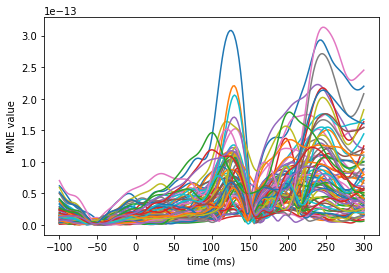

In [17]:
#plot time series
plt.plot(1e3 * stc.times, stc.data[::100, :].T)
plt.xlabel('time (ms)')
plt.ylabel('%s value' % method)
plt.show()

In [18]:
vertno_max_l, time_max_l = stc.get_peak(hemi='lh') #get left hemisphere peak
vertno_max_r, time_max_r = stc.get_peak(hemi='rh') #get right hemisphere peak

In [20]:
#use qt backend for 3d rendering
%matplotlib qt

In [21]:
#left hemisphere localization results
brain_l = stc.plot(surface='inflated', hemi='lh', subjects_dir=subjects_dir,
                 clim=dict(kind='value', lims=[1.5e-13, 1.8e-13, 2.6e-13]), #1e-13, 1.5e-13, 3e-13(ct); 1.5e-13, 1.8e-13, 2.6e-13 (ps)
                 initial_time=time_max_l, time_unit='s')
brain_l.add_foci(vertno_max_l, coords_as_verts=True, hemi='lh', color='blue',
               scale_factor=0.6)
brain_l.show_view('lateral')

((180.0, 90.0, 527.091796875, array([ 0.,  0.,  0.])), 90.0)

In [22]:
#right hemisphere localization results
brain_r = stc.plot(surface='inflated', hemi='rh', subjects_dir=subjects_dir,
                 clim=dict(kind='value', lims=[1.1e-13, 1.8e-13, 2.6e-13]), #2e-13, 2.4e-13, 3.5e-13 (ct); 1.1e-13, 1.8e-13, 2.6e-13 (ps) 
                 initial_time=time_max_r, time_unit='s')
brain_r.add_foci(vertno_max_r, coords_as_verts=True, hemi='rh', color='blue',
               scale_factor=0.6)
brain_r.show_view('lateral')

((-7.0167092985348768e-15, 90.0, 518.46453857421875, array([ 0.,  0.,  0.])),
 -90.0)